In [1]:
import numpy as np
from framework.io_functions import Reader, Writer
from framework.pre_processing import PreProcessor
from framework.dfts import DFT1D
import matplotlib.pyplot as plt
from framework.ofunction import OFunction
from framework.utilities import real_to_complex, complex_to_real, find_pixel
from framework.priors import TV, L1, Chi2
from framework.optimizer import FISTA, ADMM, SDMM, GradientBasedMethod
from framework.analytical_functions import Gaussian
from scipy.constants import c

In [2]:
def remove_channels(nu, remove_frac):
    _chansremoved = []
    while True:
        pos = np.random.randint(0,len(nu))  # get position
        width = np.random.uniform(0,100)  # get chunk size
        low = int(pos - 0.5*width)
        if low<0: low = 0
        high= int(pos + 0.5*width)
        if high>=len(nu): high = len(nu)-1

        _chansremoved.append(list(np.arange(low,high)))
        merged = list(itertools.chain(*_chansremoved))

        chans_removed = np.unique(np.ravel(np.array(merged)))
        frac = float(len(chans_removed))/float(len(nu))
        if frac > remove_frac: break

    # adjust back towards specified fraction
    # using single channel adjustments:
    while True:
        idx = np.random.randint(0,len(chans_removed))
        chans_removed = np.delete(chans_removed, idx)
        frac = float(len(chans_removed))/float(len(nu))
        if frac<=remove_frac: break

    print("Fraction removed: ",frac)
    return chans_removed

In [3]:
def make_scenario1(phi_gal, l2):
    
    p0 = 1.0
    alpha = 0.7
    nu0 = 1.4e9
    nu = c/np.sqrt(l2)
    k = (nu/nu0)**(-1*alpha)
    mu_q = p0*k*np.cos(2.*phi_gal*l2)
    mu_u = p0*k*np.sin(2.*phi_gal*l2)
    
    p = np.mean(np.sqrt(mu_q**2+mu_u**2))
    
    return mu_q, mu_u

In [4]:
def make_scenario2(phi_fg, phi_gal, l2):
    
    p_fg = 1.0
    p_gal = 0.25
    mu_q = p_fg*np.sin(2*phi_fg*l2)/(2.*phi_fg*l2) + p_gal*np.cos(2.*phi_gal*l2)
    mu_u = p_gal*np.sin(2.*phi_gal*l2)
    
    return mu_q, mu_u

In [5]:
def apply_noise(P, noise=1.0):
    q_noise = np.random.normal(loc=0.0, scale=noise, size=len(P))
    u_noise = np.random.normal(loc=0.0, scale=noise, size=len(P))
    p_noise = q_noise + 1j * u_noise
    
    P_noisy = P + p_noise
    return P_noisy

In [6]:
nu_min = 0.58e9  # minimum frequency
nu_max = 2.50e9  # maximum frequency
l2_min = (c/nu_max)**2
l2_max = (c/nu_min)**2

#nu = np.linspace(nu_min, nu_max, 512)  # make data regularly spaced in frequency
t1 = np.linspace(l2_min, l2_max, 512) # make data regularly spaced in lambda^2

nu = c/np.sqrt(t1)

In [7]:
pre_proc = PreProcessor(freqs=nu)

W, K = pre_proc.calculate_W_K()
l2, l2_ref, phi, phi_r = pre_proc.calculate_phi(W, K, times=7, verbose=True)
n = len(phi)

Minimum Lambda-squared: 0.014 m^2
Maximum Lambda-squared: 0.267 m^2
delta Lambda-squared min: 4.947e-04 m^2
delta Lambda-squared max: 0.000 m^2
delta Lambda-squared mean: 4.947e-04 m^2
FWHM of the main peak of the RMTF: 13.704 rad/m^2
Maximum recovered width structure: 218.468 rad/m^2
Maximum Faraday Depth to which one has more than 50% sensitivity: 3501.259


In [8]:
phi_gal = 50.
stokesQ, stokesU = make_scenario1(phi_gal, l2)
P = stokesQ + 1j * stokesU

# Apply noise to the data
P_noisy = apply_noise(P)

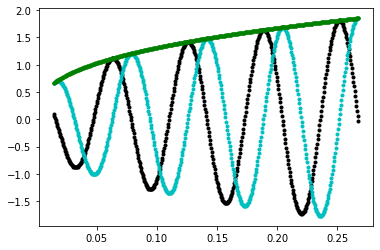

In [9]:
plt.plot(l2, P.real, 'k.', label=r"Stokes $Q$")
plt.plot(l2, P.imag, 'c.', label=r"Stokes $U$")
plt.plot(l2, np.abs(P), 'g.', label=r"$|P|$")

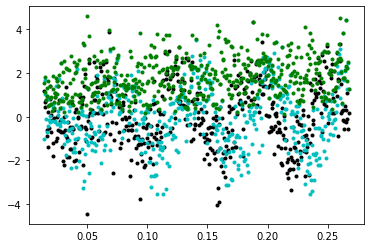

In [10]:
plt.plot(l2, P_noisy.real, 'k.', label=r"Stokes $Q$")
plt.plot(l2, P_noisy.imag, 'c.', label=r"Stokes $U$")
plt.plot(l2, np.abs(P_noisy), 'g.', label=r"$|P|$")

In [11]:
dft = DFT1D(W, K, l2, l2_ref, phi)

In [12]:
F_dirty = dft.backward(P)
F_dirty_noisy = dft.backward(P_noisy)

In [13]:
idx_noise = np.where(np.abs(phi)>3000)
noise_F = np.std(0.5*(F_dirty[idx_noise].real + F_dirty[idx_noise].imag))
noise_F_noisy = np.std(0.5*(F_dirty_noisy[idx_noise].real + F_dirty_noisy[idx_noise].imag))
print(noise_F)
print(noise_F_noisy)

0.0009992799
0.02867175


(-500.0, 500.0)

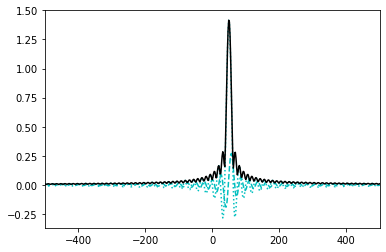

In [14]:
plt.plot(phi, F_dirty.real, 'c--', label=r"Real part")
plt.plot(phi, F_dirty.imag, 'c:', label=r"Imaginary part")
plt.plot(phi, np.abs(F_dirty), 'k-', label=r"Amplitude")
plt.xlim([-500,500])

(-500.0, 500.0)

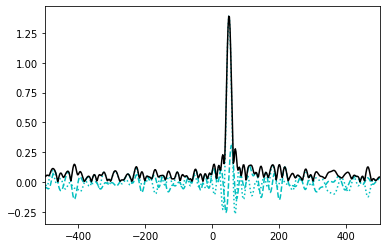

In [15]:
plt.plot(phi, F_dirty_noisy.real, 'c--', label=r"Real part")
plt.plot(phi, F_dirty_noisy.imag, 'c:', label=r"Imaginary part")
plt.plot(phi, np.abs(F_dirty_noisy), 'k-', label=r"Amplitude")
plt.xlim([-500,500])

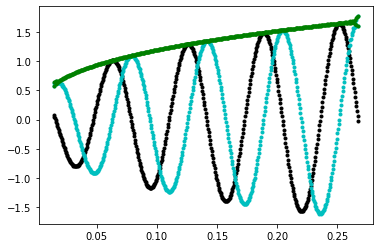

In [16]:
test_P = dft.forward_normalized(F_dirty)
plt.plot(l2, test_P.real, 'k.', label=r"Stokes $Q$")
plt.plot(l2, test_P.imag, 'c.', label=r"Stokes $U$")
plt.plot(l2, np.abs(test_P), 'g.', label=r"$|P|$")

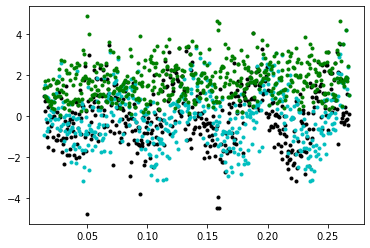

In [17]:
test_P = dft.forward_normalized(F_dirty_noisy)
plt.plot(l2, test_P.real, 'k.', label=r"Stokes $Q$")
plt.plot(l2, test_P.imag, 'c.', label=r"Stokes $U$")
plt.plot(l2, np.abs(test_P), 'g.', label=r"$|P|$")

In [33]:
noise_fista = noise_F_noisy
lambda_l1 = np.sqrt(2 * len(P) + 4 * np.sqrt(len(P)))*noise_fista
#lambda_l1 = np.sqrt(len(P))*noise_fista
#lambda_l1 = 0.5
print(np.round(lambda_l1, decimals=2))
lambda_tv = 1e-4
chi2 = Chi2(b=P, dft_obj=dft, w=W)
tv = TV(reg=lambda_tv)
l1 = L1(reg=lambda_l1)
# F_func = [chi2(P, dft, W), L1(lambda_l1)]
F_func = [chi2, l1]
f_func = [chi2]
g_func = [l1]

F_obj = OFunction(F_func)
f_obj = OFunction(f_func)
g_obj = OFunction(g_func)

F_real = complex_to_real(F_dirty_noisy)

0.96


In [34]:
opt = FISTA(F_obj=F_obj, i_guess=F_real, verbose=True, fx=chi2, gx=g_obj, noise=noise_fista)
#opt = GradientBasedMethod(F_obj=F_obj, i_guess=F_real, maxiter=1000, verbose=True)
obj, X = opt.run()
X = real_to_complex(X)

Iterations set to 33
Iteration:  0  objective function value: 329.59010


(-400.0, 400.0)

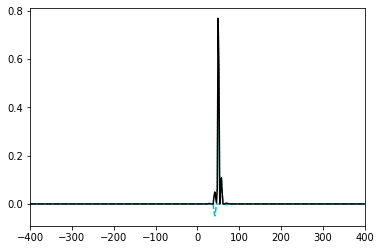

In [35]:
X_recon = X * K / n
plt.plot(phi, X_recon.real, 'c--', label=r"Real part")
plt.plot(phi, X_recon.imag, 'c:', label=r"Imaginary part")
plt.plot(phi, np.abs(X_recon), 'k-', label=r"Amplitude")
plt.xlim([-400,400])

In [36]:
np.max(np.abs(X_recon))

0.76909053

In [37]:
phi[np.argmax(np.abs(X_recon))]

49.28573392706629

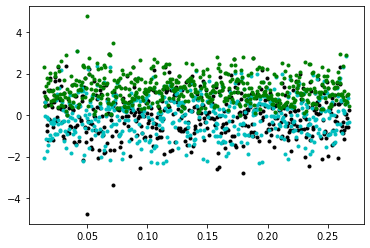

In [41]:
recon_P = dft.forward_normalized(X)
residual = P_noisy - recon_P
plt.plot(l2, residual.real, 'k.', label=r"Stokes $Q$")
plt.plot(l2, residual.imag, 'c.', label=r"Stokes $U$")
plt.plot(l2, np.abs(residual), 'g.', label=r"$|P|$")

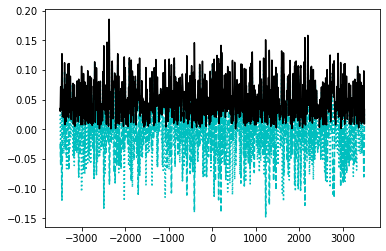

In [43]:
F_residual = dft.backward(residual)
plt.plot(phi, F_residual.real, 'c--', label=r"Real part")
plt.plot(phi, F_residual.imag, 'c:', label=r"Imaginary part")
plt.plot(phi, np.abs(F_residual), 'k-', label=r"Amplitude")
#plt.xlim([-500,500])